In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

from collections import Counter

import numpy as np

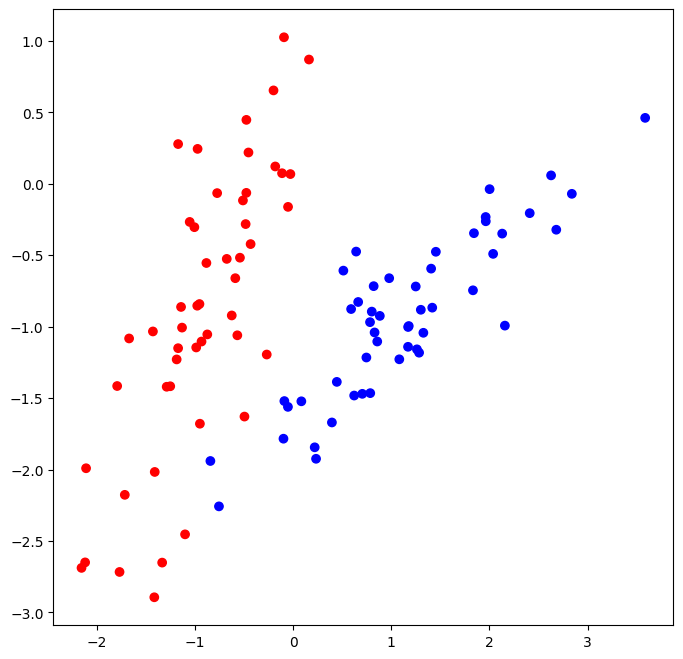

In [ ]:
# сгенерируем и визуализируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)
plt.show()

In [ ]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# Реализуем класс листа
class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        # Возвращаем класс, к которому относится большая часть объектов
        counter = Counter(self.labels)
        prediction = max(counter, key=counter.get)
        return prediction

Критерий Джини (индекс Джини)

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$ - будет характеризовать вероятность выдачи класса k

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}),$$
Его минимум достигается, когда все объекты в подмножестве относятся к одному классу, максимум — при равном содержании объектов всех классов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

In [ ]:
# Расчёт критерия Джини
def gini(labels):
    counter = Counter(labels)
    p_k = [(count / len(labels)) for count in counter.values()]
    p_k = np.array(p_k)

    impurity = 1 - sum(p_k * (1-p_k))
    return impurity

#примесь Джини, равная 0, является наилучшим возможным вариантом - вероятность ошибки случайного классификатора

Функционал качества

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

где X_{m} — множество объектов, попавших в лист на этом шаге, а
 и
 — {|X_{l} {|X_{r}множества, попадающие в левое и правое поддерево, соответственно, после гипотетического разбиения. {H(X)} — критерий информативности. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в , соответственно, задача обучения состоит в его минимизации и максимизации
 на этом шаге.

In [ ]:
# Расчёт качества
def quality(left_labels, right_labels, current_gini):
    p_l = len(left_labels) / (len(left_labels) + len(right_labels))
    p_r = len(right_labels) / (len(left_labels) + len(right_labels))
    return current_gini - p_l * gini(left_labels) - p_r * gini(right_labels)

In [ ]:
# Разбиение выборки на две части
def split(data, labels, index, t): # t - порог
    true_data = data[data[:, index] >= t] #передеаем параметры
    false_data = data[data[:, index] < t]
    true_labels = labels[data[:, index] >= t] #передаем классы
    false_labels = labels[data[:, index] < t]
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    best_quality = -1
    best_t = None
    best_index = None
    current_gini = gini(labels)

    min_leaf = 5  # минимальное количество объектов в узле - критерий останова
    t_s = set(data[:, index])  # уникальные значения признака

    for index in range(data.shape[1]):

        for t in t_s:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
                continue

            q = quality(true_labels, false_labels, current_gini)
            if q > best_quality:
                best_quality, best_t, best_index = q, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева посредством рекурсивной функции
def build_tree(data, labels):
    best_quality, best_t, best_index = find_best_split(data, labels)

    if best_quality < 0:  # если разбиение невозможно
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, best_index, best_t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(best_index, best_t, true_branch, false_branch)

In [ ]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):
    if isinstance(node, Leaf): #если лист, то конец
        return node.prediction

    if obj[node.index] >= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    return [classify_object(obj, tree) for obj in data]

In [ ]:
# Разобьём выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [ ]:
# ----------------------------------------------------------------------------------------

In [ ]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

print_tree(my_tree)

Индекс 0
Порог 0.22079911434425847
--> True:
  Индекс 0
  Порог 0.663389024866191
  --> True:
    Индекс 0
    Порог 1.1709531299081966
    --> True:
      Индекс 0
      Порог 1.8420801547405197
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 1
--> False:
  Индекс 1
  Порог -1.4172393321608008
  --> True:
    Индекс 0
    Порог -0.9749918375411485
    --> True:
      Индекс 0
      Порог -0.5097793447177874
      --> True:
        Индекс 0
        Порог -0.11161924805848533
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.8725985883473684
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.8411814419026544
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 0


In [ ]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)

In [ ]:
# Получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [ ]:
# Введём функцию подсчёта точности
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

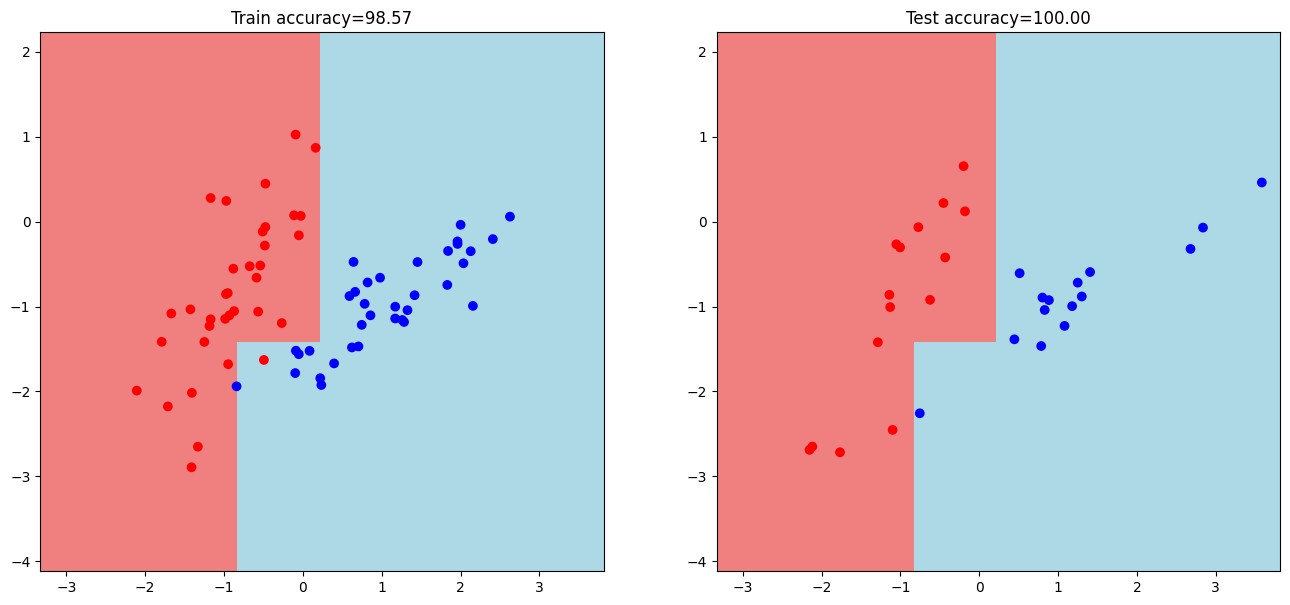

In [ ]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

#print(np.c_[xx.ravel(), yy.ravel()])

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()
